In [1]:
import fastai
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *

In [2]:
csv_path = "C:/Users/Leon/Desktop/Data_Science/Data_ML/HAM10000_kaggle/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")


,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [3]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

In [4]:
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] # returns only dx and image id column
img_to_class_dict = img_to_class_dict.to_dict('list')  # returns columns as lists in a dict
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } # returns a dict mapping image id to disease name
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [5]:
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] # path.stem returns the filename without suffix

skin_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # independent variable x is an image | dependent variabley is a category
    item_tfms=[Resize(450), DihedralItem()], # DihedralItem all 4 90 deg roatations and for each: 2 horizonntal flips -> 8 orientations
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0), # Picks a random scaled crop of an image and resize it to size
    get_items=get_image_files, # returns all images found in a folder and its subfolders
    splitter=RandomSplitter(valid_pct=0.3, seed=42), # splits the the data in train and valid 70/30 
    get_y=get_label_from_dict, # specifies how to get the label of an image
)

img_path = "C:/Users/Leon/Desktop/Data_Science/Data_ML/HAM10000_kaggle"
# skin_db.summary(img_path) # for debugging
dls = skin_db.dataloaders(img_path, bs=32) # create dataloader using img_path

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


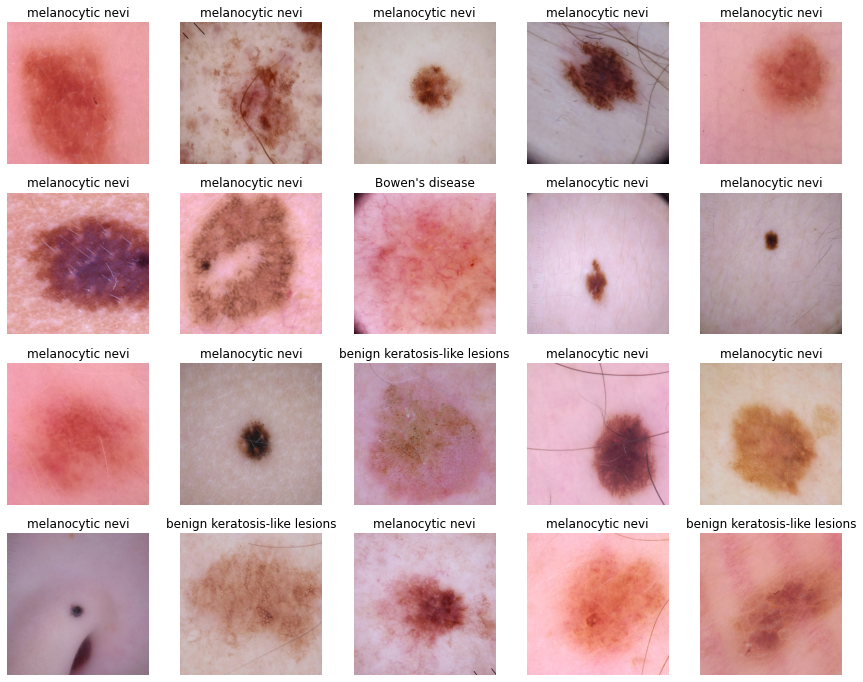

In [6]:
dls.show_batch(max_n=20, nrows=4) # show a batch of images with labels

In [9]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, partial(top_k_accuracy, k=2)], opt_func=ranger)
learn.fine_tune(epochs=50, freeze_epochs=3, base_lr=0.01, cbs=MixUp(0.5)) # use mixup with callbacks

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.941006,0.971756,0.708056,0.827230,01:45
1,1.083393,0.712719,0.744008,0.886485,01:44
2,0.976605,0.646885,0.763316,0.902463,01:44


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.807214,0.520651,0.814248,0.929760,01:49
1,0.752313,0.480238,0.830892,0.942743,01:49
2,0.693902,0.453960,0.838216,0.941744,01:50
3,0.668929,0.441417,0.834887,0.943742,01:50
4,0.683564,0.424040,0.851198,0.951731,01:49
5,0.690427,0.431610,0.846871,0.955393,01:49
6,0.675419,0.417604,0.855859,0.957390,01:50
7,0.644647,0.416192,0.855859,0.953063,01:47
8,0.649609,0.537722,0.807923,0.921771,01:47
9,0.669697,0.389777,0.860186,0.959720,01:48


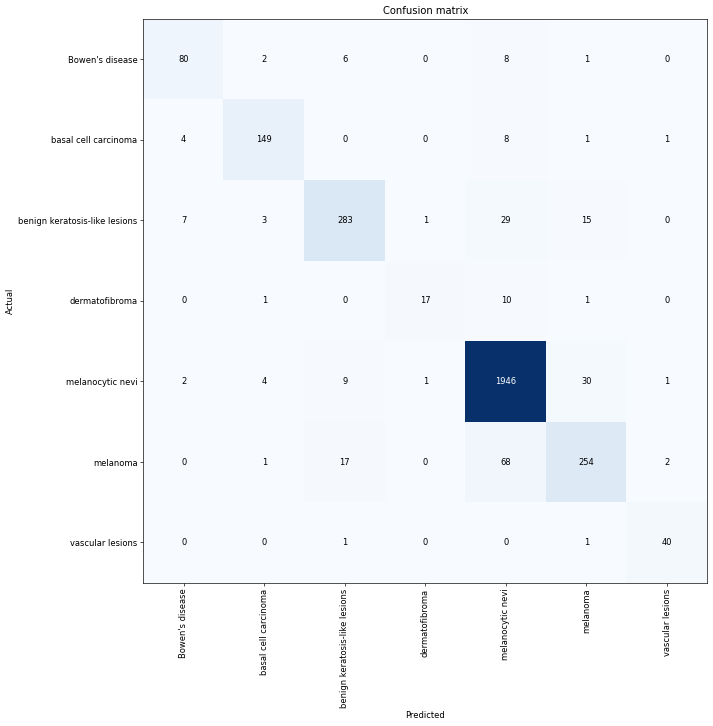

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [10]:
learn.export('Models/skin_disease_50_res18_9217.pkl')